### A. Import dữ liệu cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import re

In [2]:
trending_videos = pd.read_csv('Data/trending_videos.csv', index_col=False)
trending_videos_unique = pd.read_csv('Data/trending_videos_unique.csv', index_col=False)

### B. Trực quan hoá

#### 1. Phân tích tổng quan

##### a. Thời điểm đăng trong ngày của video

In [3]:
upload_time = trending_videos_unique[['published_at']].copy()
upload_time['published_at'] = pd.to_datetime(upload_time['published_at'])
upload_time['hour'] = upload_time['published_at'].dt.hour
time_ranges = []
video_counts = []
for i in range(24):
    time_ranges.append(f'{i}h - {i+1}h')
    video_counts.append(upload_time[(upload_time['hour'] >= i) & (upload_time['hour'] < i+1)].shape[0])

time_video_df = pd.DataFrame({'Time Range': time_ranges, 'Video Count': video_counts})

In [4]:
time_video_df

Time Range  Video Count
0     0h - 1h           60
1     1h - 2h           32
2     2h - 3h           18
3     3h - 4h           22
4     4h - 5h           34
5     5h - 6h           25
6     6h - 7h           17
7     7h - 8h           18
8     8h - 9h           34
9    9h - 10h           58
10  10h - 11h          112
11  11h - 12h          162
12  12h - 13h           56
13  13h - 14h           46
14  14h - 15h           59
15  15h - 16h           93
16  16h - 17h          106
17  17h - 18h          282
18  18h - 19h          309
19  19h - 20h          213
20  20h - 21h          258
21  21h - 22h          124
22  22h - 23h           83
23  23h - 24h           90

In [5]:
fig = px.box(upload_time, 
       x='hour', 
       title='Box Plot of Video Upload Times')
fig.update_xaxes(tickmode='linear', dtick=1)
fig.show()

In [6]:
fig = px.bar(time_video_df, 
             x='Time Range', 
             y='Video Count', 
             title='Number of Videos Uploaded in Each Time Range')
fig.show()

##### b. Thời gian tồn tại trên trending

In [7]:
time_on_trending = trending_videos_unique[['trending_time']].copy()
time_on_trending['trending_time'] = pd.to_timedelta(time_on_trending['trending_time'])
time_on_trending['trending_time'] = time_on_trending['trending_time'].dt.days
time_on_trending = time_on_trending.groupby('trending_time').size()
time_on_trending = time_on_trending.reset_index(name='count')
time_on_trending

trending_time  count
0               1    147
1               2    133
2               3    153
3               4    186
4               5    191
5               6    200
6               7    218
7               8    191
8               9    159
9              10    143
10             11    106
11             12    124
12             13     93
13             14     84
14             15     55
15             16     45
16             17     23
17             18     26
18             19     15
19             20     11
20             21      4
21             22      1
22             23      1
23             26      1
24             27      1

In [8]:
fig = px.box(time_on_trending, 
       x='trending_time',
       labels={'trending_time':'Trending time'},
       title='Box plot of time on trending')
fig.update_xaxes(tickmode='linear', dtick=1)
fig.show()

In [9]:
fig = px.bar(time_on_trending,
             x='trending_time', 
             y='count',
             labels={'trending_time':'Days','count':'Videos'},
             title='Bar plot trending time')
fig.update_xaxes(tickmode='linear', dtick=1)
fig.show()

#### 2. Phân tích theo chủ đề

##### a. Phần trăm của từng chủ đề trên trending

In [10]:
category_counts = trending_videos['category'].copy().value_counts()
category_full = category_counts.reset_index()
category_full

category  count
0          Entertainment   6546
1         People & Blogs   4992
2                  Music   1269
3                 Gaming   1207
4                 Comedy    770
5                 Sports    609
6          Howto & Style    543
7        News & Politics    489
8       Film & Animation    432
9         Pets & Animals    271
10      Autos & Vehicles    144
11  Science & Technology    126
12       Travel & Events     62
13             Education     52

In [11]:
threshold = 500
category_pie = category_full.copy()
category_pie['category'] = category_pie['category'].apply(lambda x: x if category_counts[x] >= threshold else 'Others')
category_pie = category_pie.groupby('category').sum().reset_index()

In [12]:
px.pie(category_pie, values='count', names='category', title='Percent of categories')

##### b. Trung bình lượt tương tác theo chủ đề

In [13]:
general_category = trending_videos[['category', 'view_count', 'like_count', 'comment_count']]
general_category = general_category.groupby('category').mean().reset_index()
general_category['like_to_view'] = (general_category['like_count'] / general_category['view_count']) * 100
general_category['comment_to_view'] = (general_category['comment_count'] / general_category['view_count'])* 100

In [14]:
general_category

category    view_count    like_count  comment_count  \
0       Autos & Vehicles  3.107792e+06  6.514688e+04     373.597222   
1                 Comedy  2.000528e+07  3.692852e+05     885.325974   
2              Education  1.414157e+07  1.423025e+05     689.653846   
3          Entertainment  1.566323e+07  4.499113e+05    5879.031011   
4       Film & Animation  2.598126e+07  1.114053e+06    1956.761574   
5                 Gaming  1.139973e+07  4.372097e+05    1862.311516   
6          Howto & Style  3.423671e+07  6.044556e+05     829.574586   
7                  Music  1.078366e+07  3.371908e+05   27022.155240   
8        News & Politics  2.137084e+06  3.040098e+04     686.476483   
9         People & Blogs  1.713809e+07  3.889904e+05    1859.762220   
10        Pets & Animals  3.626297e+07  8.398367e+05    2543.479705   
11  Science & Technology  2.823146e+07  1.283625e+06    2244.238095   
12                Sports  1.523790e+07  3.927227e+05    1815.942529   
13       Travel & Events  9.218066e+07  1.889367e+06    7572.516129   

    like_to_view  comment_to_view  
0       2.096243         0.012021  
1       1.845939         0.004425  
2       1.006271         0.004877  
3       2.872405         0.037534  
4       4.287909         0.007531  
5       3.835263         0.016336  
6       1.765519         0.002423  
7       3.126868         0.250584  
8       1.422545         0.032122  
9       2.269742         0.010852  
10      2.315962         0.007014  
11      4.546790         0.007949  
12      2.577276         0.011917  
13      2.049635         0.008215

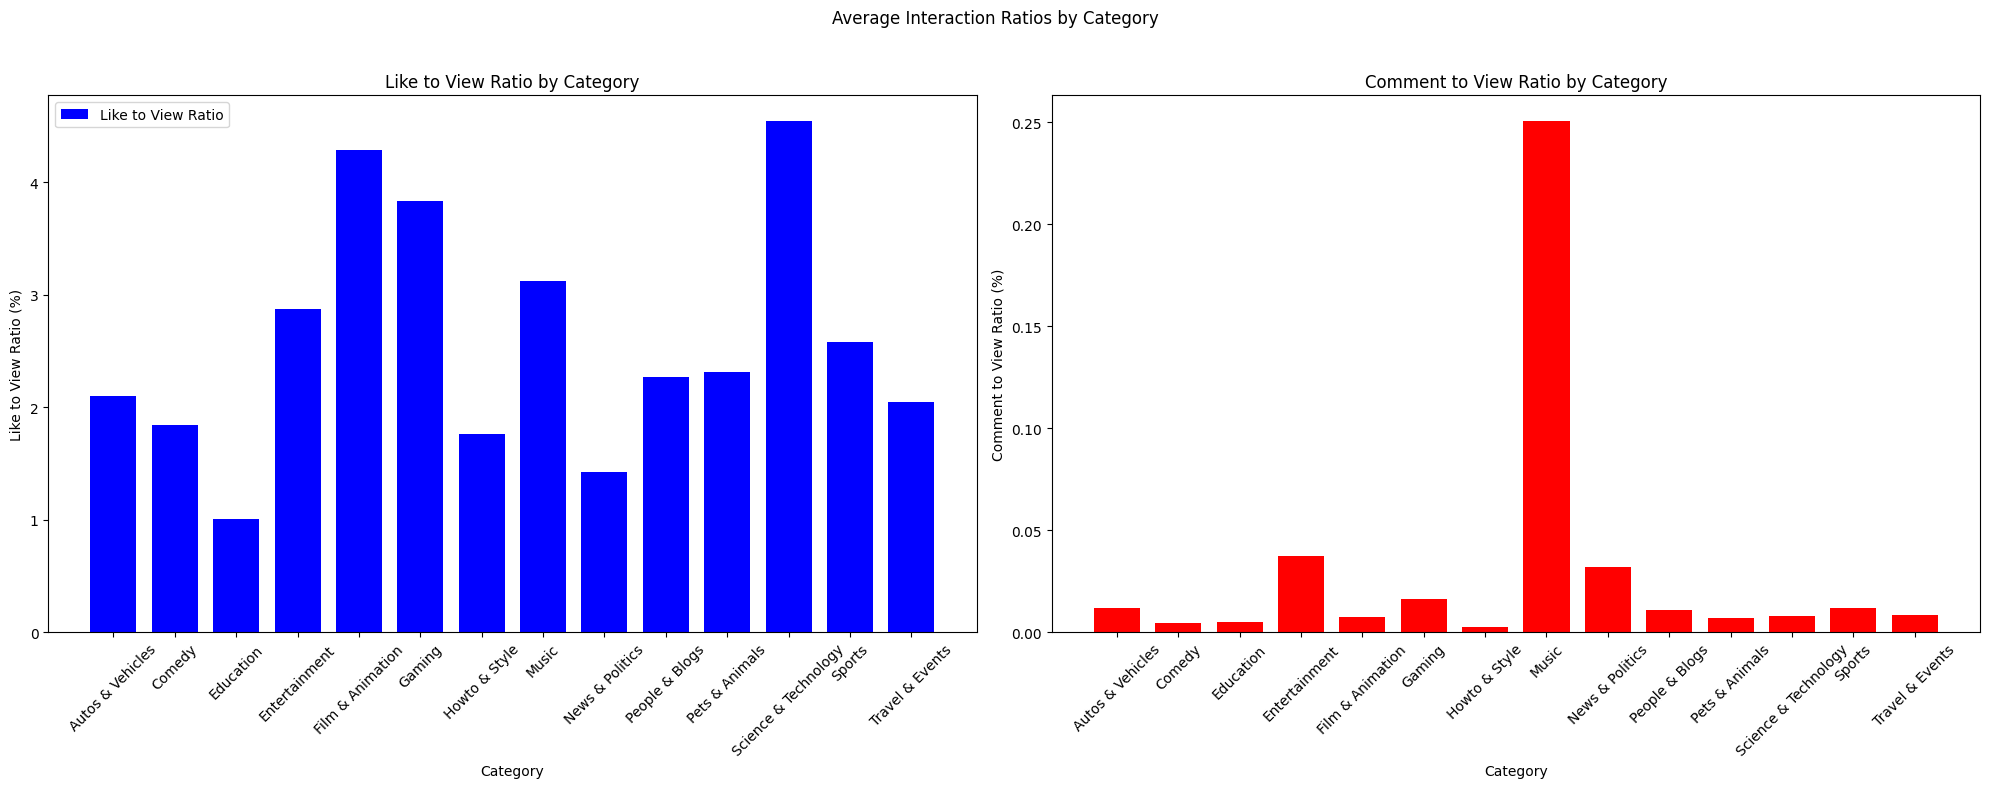

In [15]:
x = range(len(general_category['category']))
width = 0.75
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].bar(x, general_category['like_to_view'], width=width, label='Like to View Ratio', color='b')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Like to View Ratio (%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(general_category['category'], rotation=45)
axes[0].tick_params(axis='y')
axes[0].set_title('Like to View Ratio by Category')
axes[0].legend()

axes[1].bar(x, general_category['comment_to_view'], width=width, label='Comment to View Ratio', color='r')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Comment to View Ratio (%)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(general_category['category'], rotation=45)
axes[1].tick_params(axis='y')
axes[1].set_title('Comment to View Ratio by Category')

plt.suptitle('Average Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### c. Thời gian trending trung bình của chủ đề

In [16]:
trending_category = trending_videos_unique[['category', 'trending_time']].copy()
trending_category['trending_time'] = pd.to_timedelta(trending_category['trending_time'])
trending_category = trending_category.groupby('category').mean()
trending_category = trending_category / np.timedelta64(1, 'h') #change days -> hour
trending_category = trending_category.reset_index()
trending_category = trending_category.sort_values('trending_time')

In [17]:
trending_category

category  trending_time
12                Sports     134.181818
8        News & Politics     148.148148
5                 Gaming     150.523077
4       Film & Animation     162.830769
1                 Comedy     167.357143
6          Howto & Style     170.153846
11  Science & Technology     179.294118
9         People & Blogs     182.666667
3          Entertainment     198.908189
2              Education     212.000000
0       Autos & Vehicles     219.000000
10        Pets & Animals     228.413793
7                  Music     247.680000
13       Travel & Events     297.600000

In [18]:
px.bar(trending_category, 
       x='trending_time', 
       y='category', 
       labels={'category': 'Category', 'trending_time': 'Average Trending Time (hours)'}, 
       title='Average Trending Time by Category')

#### 3. Phân tích theo nội dung chi tiết

##### a. Từ khoá trong tag

In [19]:
video_tags = trending_videos_unique['video_tags'].copy()
video_tags = video_tags.dropna()
tags_list = []
for tagline in video_tags:
    tags_list.extend(tagline.split(','))
count_tags = Counter(tags_list)
tags_df = pd.DataFrame(count_tags.items(),columns=['tag','count'])
tags_df_sort = tags_df.sort_values('count',ascending=True).tail(25)

In [20]:
tags_df_sort

tag  count
323       chung kết liên quân     57
314      đấu trường danh vọng     60
316                       aov     61
317                    garena     61
315   garena liên quân mobile     61
312          liên quân mobile     61
311          garena liên quân     61
313                 liên quân     62
746                 phim ngắn     65
319                   Esports     72
748                       hài     74
15               tiktok trend     77
347                tiktok hài     79
342           hài ngắn tiktok     82
747                hài tiktok     82
16            tiktok việt nam     89
343                  hài ngắn     91
427                  giải trí     93
361                    comedy    103
205           tiktok hài hước    119
428                  hài hước    133
137                     funny    135
3                     tik tok    202
4                      tiktok    309
21                     shorts    393

In [21]:

px.bar(tags_df_sort,
       x='count', 
       y='tag', 
       title='Top 25 Tags by Count',
       height=600,width=800)

#### 4. Phân tích theo thời gian

##### a. Độ dài video theo thời gian

In [22]:
duration_videos = trending_videos[['snapshot_date', 'duration']].copy()
duration_videos['month'] = pd.to_datetime(duration_videos['snapshot_date']).dt.to_period('M')
bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]
labels = ['<1p', '1-10p', '10-60p', '>60p']
duration_videos['duration_time'] = pd.cut(duration_videos['duration'], bins=bins, labels=labels, right=False)
duration_videos = duration_videos.groupby(['month', 'duration_time'], observed=False).size().unstack(fill_value=0)
duration_videos = duration_videos.reset_index()

In [23]:
duration_videos

duration_time    month   <1p  1-10p  10-60p  >60p
0              2023-11   453    424     173   382
1              2023-12   777    291     146   245
2              2024-01   847    212     117   216
3              2024-02   998    196      29   126
4              2024-03   948    288      56   105
5              2024-04  1063    223      86    72
6              2024-05  1191    157      77   107
7              2024-06  1001    256     134    77
8              2024-07   912    278      53   248
9              2024-08   912    227      73   317
10             2024-09   972    152      47   298
11             2024-10  1081    163      34   272

In [24]:
duration_videos = trending_videos[['snapshot_date', 'duration']].copy()
duration_videos['week'] = pd.to_datetime(duration_videos['snapshot_date']).dt.to_period('W')
bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]
labels = ['<1p', '1-10p', '10-60p', '>60p']
duration_videos['duration_time'] = pd.cut(duration_videos['duration'], bins=bins, labels=labels, right=False)
duration_videos = duration_videos.groupby(['week', 'duration_time'], observed=False).size().unstack(fill_value=0)
duration_videos = duration_videos.reset_index()

for col in duration_videos.columns[1:]:
    duration_videos[col] = duration_videos[col].cumsum()


In [25]:
duration_videos['week'] = duration_videos['week'].astype(str)
duration_videos_long = duration_videos.melt(id_vars='week', 
											var_name='time', 
											value_name='count')
fig = px.bar(duration_videos_long, 
             x='count', 
             y='time',
             orientation='h', 
             color='time', 
             animation_frame='week', 
             title='Video Duration Over Time',
             labels={'count': 'Number of Videos', 'time': 'Duration Range', 'week': 'Week'},
             text='count')
fig.show()

In [26]:
# # # pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None
# duration_percentage = duration_videos.div(duration_videos.sum(axis=1), axis=0) * 100
# duration_percentage

In [27]:
# duration_percentage.plot(kind='line', figsize=(12, 6))
# plt.title('Phần trăm của từng thời lượng video theo thời gian')
# plt.xlabel('Thời gian')
# plt.ylabel('Phần trăm')
# plt.legend(title='Độ dài')
# plt.show()

##### b. Chủ đề theo thời gian

In [28]:
video_counts = 300
category_area = trending_videos[['snapshot_date', 'category']].copy()
category_area['category'] = category_area['category'].apply(lambda x: x if category_counts[x] >= video_counts else 'Others')
category_area = category_area.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)
category_area.index = pd.to_datetime(category_area.index)
category_area['month'] = category_area.index.to_period('W')
category_area = category_area.groupby('month').sum()
category_area = category_area.reset_index()

In [29]:
for col in category_area.columns[1:]:
    category_area[col] = category_area[col].cumsum()

In [30]:
category_area['month'] = category_area['month'].astype(str)
category_area_long = category_area.melt(id_vars='month', 
											var_name='categories', 
											value_name='count')
category_area_long = category_area_long.sort_values(by=['month', 'count'], ascending=[True, False])

import plotly.graph_objects as go

import plotly.graph_objects as go
import plotly.express as px

def create_animated_bar_chart(category_area_long):
    # Chuẩn bị dữ liệu
    months = category_area_long['month'].unique()
    
    # Tạo frames
    frames = []
    frame_data = []
    
    for month in months:
        df_month = category_area_long[category_area_long['month'] == month]
        
        # Tìm max count cho tháng này
        max_count_this_month = df_month['count'].max()
        
        # Sắp xếp theo count giảm dần để hiển thị đẹp
        df_month = df_month.sort_values('count', ascending=True)
        
        frame = go.Frame(
            data=[go.Bar(
                x=df_month['count'], 
                y=df_month['categories'],
                orientation='h',
                text=df_month['count'],
                textposition='outside',
                textfont=dict(size=10),
                marker_color=px.colors.qualitative.Plotly[:len(df_month)]
            )],
            name=str(month),
            layout=go.Layout(
                xaxis=dict(
                    # Giới hạn x từ 0 đến max của frame này với padding 10%
                    range=[0, max_count_this_month * 1.1]
                )
            )
        )
        
        frames.append(frame)
    
    # Dữ liệu ban đầu (tháng đầu tiên)
    initial_data = category_area_long[category_area_long['month'] == months[0]]
    initial_data = initial_data.sort_values('count', ascending=True)
    max_count_first_month = initial_data['count'].max()
    
    # Tạo figure
    fig = go.Figure(
        data=[go.Bar(
            x=initial_data['count'], 
            y=initial_data['categories'],
            orientation='h',
            text=initial_data['count'],
            textposition='outside',
            textfont=dict(size=10),
            marker_color=px.colors.qualitative.Plotly[:len(initial_data)]
        )],
        layout=go.Layout(
            title='Video Duration Over Time',
            xaxis_title='Number of Videos',
            yaxis_title='Duration Range',
            height=600,
            xaxis=dict(
                # Giới hạn x ban đầu theo max của tháng đầu tiên
                range=[0, max_count_first_month * 1.1]
            ),
            updatemenus=[{
                'buttons': [
                    {
                        'args': [None, {
                            'frame': {'duration': 800, 'redraw': False},
                            'fromcurrent': True, 
                            'transition': {'duration': 600, 'easing': 'bounce-in-out'}
                        }],
                        'label': 'Play',
                        'method': 'animate'
                    }
                ]
            }]
        ),
        frames=frames
    )
    
    # Cấu hình layout bổ sung
    fig.update_layout(showlegend=False)
    
    return fig

# Sử dụng hàm
fig = create_animated_bar_chart(category_area_long)
fig.show()

In [31]:
# pd.options.display.float_format = None

# category_area = category_area.div(category_area.sum(axis=1), axis=0) * 100
# category_area.plot(kind='area', figsize=(12, 6))
# plt.title('Percentage of Each Category per Month')
# plt.xlabel('Month')
# plt.ylabel('Percentage')
# plt.legend(title='Category')
# plt.show()

##### c. Trung bình tương tác theo thời gian

In [32]:
pd.options.display.float_format = '{:,.0f}'.format

general_videos = trending_videos[["view_count", "like_count", "comment_count"]].copy()
general_videos.describe()

view_count  like_count  comment_count
count      17,512      17,512         17,512
mean   16,637,431     440,481          5,097
std    29,072,038   1,001,437         22,914
min       187,782           0              0
25%     1,705,248      28,790            136
50%     3,499,882      63,666            427
75%    18,009,186     323,611          2,064
max   290,801,447  11,040,218        438,822

In [33]:
general_month = trending_videos[["snapshot_date", "view_count", "like_count", "comment_count"]].copy()

general_month['snapshot_date'] = pd.to_datetime(general_month['snapshot_date'])

general_month['snapshot_date'] = general_month['snapshot_date'].dt.to_period('M')

general_month = general_month.groupby('snapshot_date').mean().reset_index()

general_month

snapshot_date  view_count  like_count  comment_count
0        2023-11   7,793,901     209,684          7,448
1        2023-12   8,396,831     247,525          3,497
2        2024-01  11,770,799     308,438          2,803
3        2024-02  16,946,634     421,504          3,429
4        2024-03  19,947,261     515,162          6,439
5        2024-04  18,610,296     520,917          4,341
6        2024-05  22,734,065     600,849          3,302
7        2024-06  20,171,795     525,868          6,084
8        2024-07  21,877,066     660,230          9,501
9        2024-08  16,164,299     434,596          6,374
10       2024-09  17,392,938     403,809          3,456
11       2024-10  17,182,171     417,986          4,334

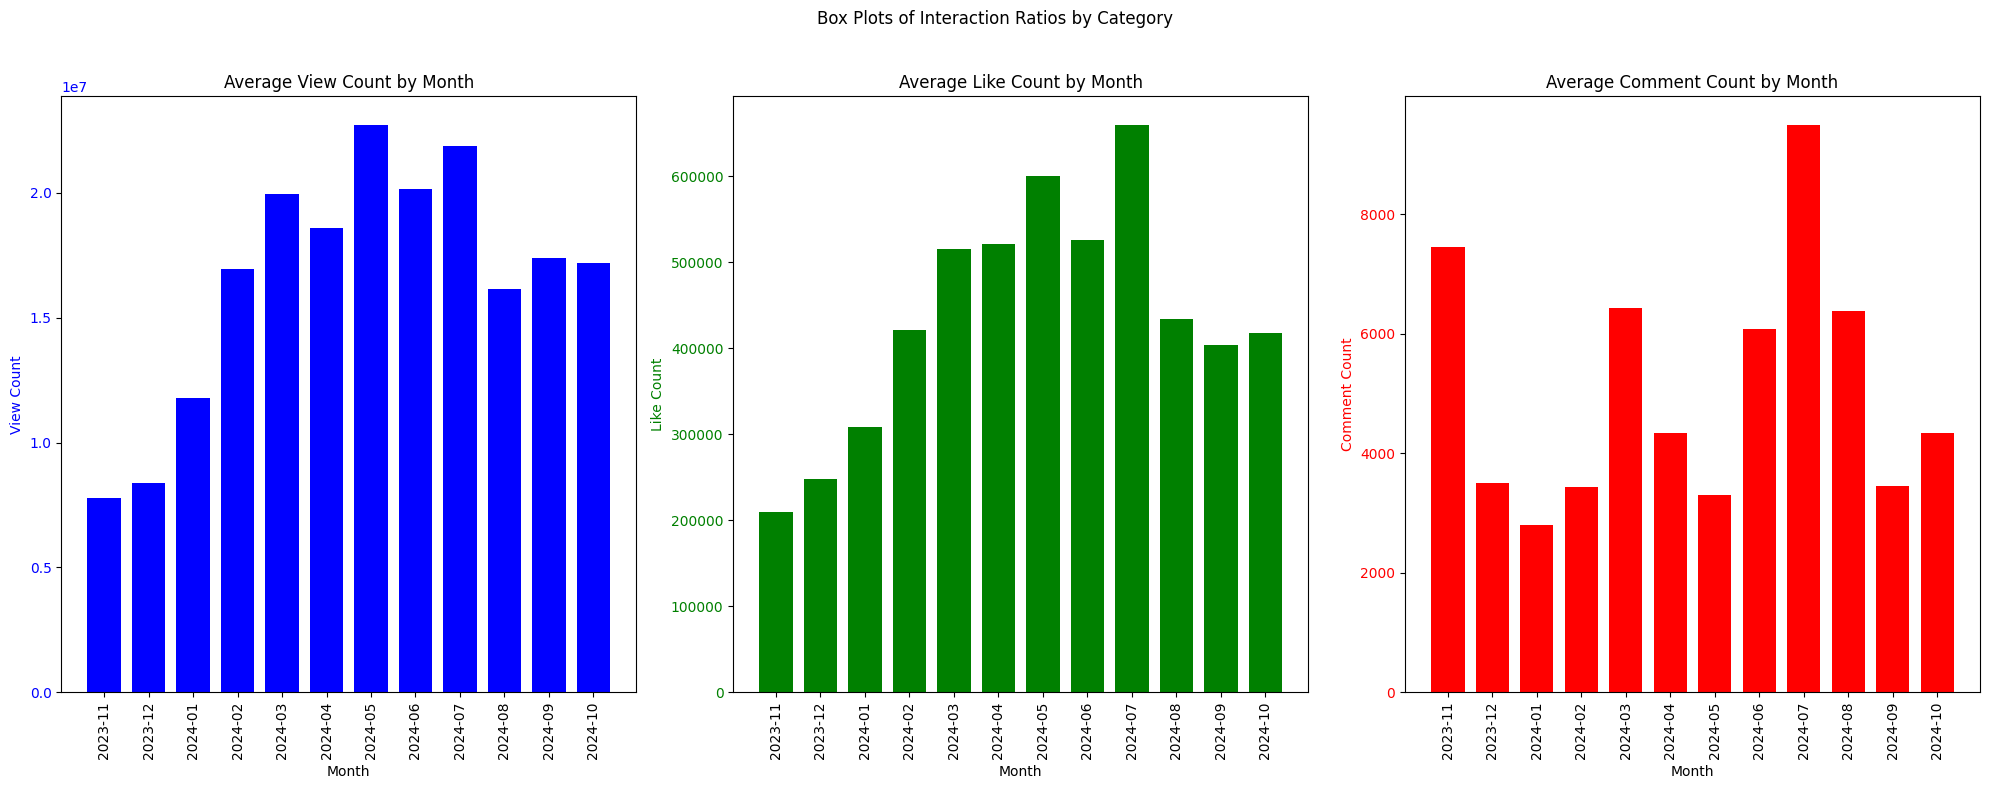

In [34]:
x = range(len(general_month['snapshot_date']))
width = 0.75
ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

axes[0].bar(x, general_month['view_count'], width=width, label='View Count', color='b')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('View Count', color='b')
axes[0].set_xticks(x)
axes[0].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[0].tick_params(axis='y', labelcolor='b')
axes[0].set_title('Average View Count by Month')

axes[1].bar(x, general_month['like_count'], width=width, label='Like Count', color='g')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Like Count', color='g')
axes[1].set_xticks(x)
axes[1].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[1].tick_params(axis='y', labelcolor='g')
axes[1].set_title('Average Like Count by Month')

axes[2].bar(x, general_month['comment_count'], width=width, label='Comment Count', color='r')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Comment Count', color='r')
axes[2].set_xticks(x)
axes[2].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[2].tick_params(axis='y', labelcolor='r')
axes[2].set_title('Average Comment Count by Month')

plt.suptitle('Box Plots of Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()